Implentation of LeNet-5

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from load_and_generate import *


## Load datasets

# load test_set 

In [ ]:
pickle_file = 'exploration.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory


  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

In [3]:
train_dataset = np.concatenate((train_dataset,test_dataset), axis=0)
train_labels = np.concatenate((train_labels,test_labels), axis=0)

pickle_file = 'test.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  test_dataset_ = save['test_dataset']
  test_labels_ = save['test_labels']
  del save  # hint to help gc free up memory

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset_.shape, test_labels_.shape)

ix= np.random.random_integers(0, test_dataset_.shape[0], 10000)
test_dataset, test_labels =  test_dataset_[ix, :, :], test_labels_[ix] 

Training set (12648, 32, 32) (12648,)
Validation set (1406, 32, 32) (1406,)
Test set (54503, 32, 32) (54503,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
image_width = 32
image_height = 32

num_labels = 2
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_height, image_width, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (12648, 32, 32, 1) (12648, 2)
Validation set (1406, 32, 32, 1) (1406, 2)
Test set (10000, 32, 32, 1) (10000, 2)


In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [6]:
def randomize(dataset, labels):
    "Randomize a dataset"
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:, :, :]
    shuffled_labels = labels[permutation, :]
    return shuffled_dataset, shuffled_labels

# 1. Lenet-5

In [7]:
#Lenet 5 implementation
#http://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/

class lenet5():

    def __init__(self, train_dataset, valid_dataset, test_dataset, train_labels,
                 valid_labels, test_labels,**kwargs):
        self.image_width = 32 #dimensions of the images
        self.image_height = 32
        self.num_channels = 1 # grayscale
        self.num_labels = 2 #label 0 and 1
        self.recording_step = 50 # indicates the frequency of saving the evaluation 
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset 
        self.test_dataset = test_dataset
        
        self.train_labels = train_labels
        self.valid_labels = valid_labels 
        self.test_labels = test_labels
        
        self.train_accuracy_array = []
        self.train_auc_array = []
        self.valid_accuracy_array = []
        self.valid_auc_array = []
        self.test_accuracy_array = []
        self.test_auc_array = []
        self.pred_step_array = []
        
        self.layer1_weights = []
        self.layer1_biases = []
        self.layer1_activation = []
        
        if kwargs is not None:
            for key, value in kwargs.iteritems():
                if key == "recording_step":
                    self.recording_step = value
                if key == "num_labels":
                    self.num_labels = value        
    def lenet5_run(self, batch_size_array = 5, lr_array =0.01, beta_array = .0):
                
        image_width = self.image_width
        image_height = self.image_height 
        num_channels = self.num_channels
        num_labels = self.num_labels
        
        self.train_accuracy_array = []
        self.train_auc_array = []
        self.valid_accuracy_array = []
        self.valid_auc_array = []
        self.test_accuracy_array = []
        self.test_auc_array = []
        self.pred_step_array = []
        
        self.batch_size_array = batch_size_array
        self.lr_array = lr_array
        self.beta_array = beta_array
        
        from sklearn.metrics import roc_auc_score

        for i, batch_size in enumerate(batch_size_array):

            print ("batch size:%d \n"%batch_size)
            print ("regularization : %.5f\n"%beta_array[i])
            print ("learning rate : %.5f\n"%lr_array[i])
            num_steps = int(self.train_dataset.shape[0] // batch_size)
            print ("num_steps:%d" %num_steps)
            #batch_size = 10
            num_channels = self.num_channels
            stride = 1 #basic stride

            #Depth of Lenet-5 layers
            depth_1 = 6
            depth_2 = 6
            depth_3 = 16
            depth_4 = 16
            depth_5 = 120
            
            #Size of the filters
            patch_size_1 = 5
            patch_size_2 = 2
            patch_size_3 = 5
            patch_size_4 = 2
            patch_size_5 = 5
            
            train_accuracy = []
            train_auc = []
            valid_accuracy = []
            valid_auc = []
            test_accuracy = []
            test_auc = []
            pred_step = []


            graph = tf.Graph()

            with graph.as_default():

              # Input data.
              tf_train_dataset = tf.placeholder(
                tf.float32, shape=(batch_size, image_height, image_width, num_channels))
              tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
              tf_train_dataset_full = tf.constant(train_dataset)
              tf_valid_dataset = tf.constant(valid_dataset)
              tf_test_dataset = tf.constant(test_dataset)
              tf_step = tf.placeholder(tf.float32, shape=())

              # Variables.
              layer1_weights = tf.Variable(tf.truncated_normal(
                  [patch_size_1, patch_size_1, num_channels, depth_1], stddev=0.1))
              layer1_biases = tf.Variable(tf.zeros([depth_1]))
              layer3_weights = tf.Variable(tf.truncated_normal(
                  [patch_size_3, patch_size_3, depth_2, depth_3], stddev=0.1))
              layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]))


              layer5_weights = tf.Variable(tf.truncated_normal(
                     [400, depth_5], stddev=0.1)) #modified for variable height and width  

              layer5_biases = tf.Variable(tf.constant(1.0, shape=[depth_5]))
              layer6_weights = tf.Variable(tf.truncated_normal(
                  [depth_5, num_labels], stddev=0.1))
              layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

              conv1_output =  tf.Variable(tf.truncated_normal([int(batch_size), 28, 28, 6], stddev=0.1))
    
              # Model.
              def model(data):
                #First CONV layer (CONV1)
                conv1 = tf.nn.conv2d(data, layer1_weights, [1, stride, stride, 1], padding='VALID')
                conv1_output = tf.identity(conv1)
                print (conv1.get_shape().as_list()) #check dimensions
                #Relu after CONV1
                hidden1 = tf.nn.relu(conv1 + layer1_biases) 
                # First POOL layer
                pool2 = tf.nn.max_pool(hidden1, ksize=[1, patch_size_2, patch_size_2, 1], strides=[1, patch_size_2, patch_size_2, 1], 
                                       padding='VALID')
                print (pool2.get_shape().as_list()) #check dimensions
                #Second CONV layer (CONV2)
                conv3 = tf.nn.conv2d(pool2, layer3_weights, [1, stride, stride, 1], padding='VALID')
                print (conv3.get_shape().as_list())
                #Relu after CONV2
                hidden3 = tf.nn.relu(conv3 + layer3_biases)
                # Second POOL layer
                pool4 = tf.nn.max_pool(hidden3, ksize=[1,  patch_size_4, patch_size_4 , 1], strides=[1, patch_size_4, patch_size_4, 1], 
                                       padding='VALID')    

                print (pool4.get_shape().as_list()) #check dimensions
                shape = pool4.get_shape().as_list() 

                reshape = tf.reshape(pool4, [shape[0], shape[1] * shape[2] * shape[3]]) # reshape to 2D    
                #Relu and first FC after CONV2
                hidden5 = tf.nn.relu(tf.matmul(reshape, layer5_weights) + layer5_biases)
                print (hidden5.get_shape().as_list())  #check dimensions
                #Second FC layers
                return (tf.matmul(hidden5, layer6_weights) + layer6_biases) 


              # Training computation.
              logits = model(tf_train_dataset)
              #print (logits.get_shape().as_list())  
              loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))


              #Regularization: 

              regularization_beta = beta_array[i] 
              regularizers = (tf.nn.l2_loss(layer5_weights) + tf.nn.l2_loss(layer5_biases) + 
                               tf.nn.l2_loss(layer6_weights) + tf.nn.l2_loss(layer6_biases)) #Minimizing loss in FC layers

              loss = loss + regularization_beta * regularizers
              # Optimizer.
              # Optimizer.
              # We are going to find the minimum of this loss using gradient descent.
              #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
              #decaying learning rate:
              starting_learning_rate = lr_array[i]
              learning_rate = tf.train.exponential_decay(starting_learning_rate, tf_step, num_steps, 0.96, 
                                                 staircase=True) #decay after each epoch
              optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  

              # Predictions for the training, validation, and test data.
              train_prediction = tf.nn.softmax(logits)
              train_prediction_full = tf.nn.softmax(model(tf_train_dataset_full))
              valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
              test_prediction = tf.nn.softmax(model(tf_test_dataset))


            with tf.device('/gpu:0'):
                with tf.Session(graph=graph) as session:
                  tf.initialize_all_variables().run()
                  print('Initialized')
                  for step in range(num_steps):
                    offset = (step * batch_size) % (self.train_labels.shape[0] - batch_size)
                    batch_data = self.train_dataset[offset:(offset + batch_size), :, :, :]
                    batch_labels = self.train_labels[offset:(offset + batch_size), :]
                    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_step : step}
                    _, l, predictions = session.run(
                      [optimizer, loss, train_prediction], feed_dict=feed_dict)
                    if (step % 250 == 0):
                      print('Minibatch loss at step %d: %f' % (step, l))
                      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                      print('Validation accuracy: %.1f%%' % accuracy(
                        valid_prediction.eval(), self.valid_labels))
                      print('AUC: %.3f' %  roc_auc_score(self.valid_labels, valid_prediction.eval()))
                      print (".................")

                    if (step % self.recording_step == 0):
                      train_accuracy.append(accuracy(
                            train_prediction_full.eval(), self.train_labels))
                      train_auc.append(roc_auc_score(self.train_labels, train_prediction_full.eval()))
                      valid_accuracy.append(accuracy(
                            valid_prediction.eval(), self.valid_labels))
                      valid_auc.append(roc_auc_score(self.valid_labels, valid_prediction.eval()))
                      test_accuracy.append(accuracy(
                            test_prediction.eval(), self.test_labels))
                      test_auc.append(roc_auc_score(self.test_labels, test_prediction.eval()))
                      pred_step.append(step)
                      self.layer1_weights.append(layer1_weights.eval())
                      self.layer1_biases.append(layer1_biases.eval())
                      self.layer1_activation.append(conv1_output.eval())

                  self.train_accuracy_array.append(train_accuracy)
                  self.train_auc_array.append(train_auc)
                  self.valid_accuracy_array.append(valid_accuracy)
                  self.valid_auc_array.append(valid_auc)
                  self.test_accuracy_array.append(test_accuracy)
                  self.test_auc_array.append(test_auc)
                  self.pred_step_array.append(pred_step)
                  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), self.test_labels))
                  print('Test AUC ROC: %.3f' %  roc_auc_score(self.test_labels, test_prediction.eval())) 
                  print("-----------------------------------------\n")
                session.close()
    def plot_auc(self, sweep_variable):
        for i, self.pred_step in enumerate(self.pred_step_array):
            plt.plot(self.pred_step, self.valid_auc_array[i], label= 'val %.3f'%sweep_variable[i])
            #plt.plot(pred_step_array[i],test_auc_array[i], label= 'test %.3f'%lr_array[i])
        plt.xlabel('steps')
        plt.ylabel('AUC')
        plt.legend(loc= "best")
        plt.title ("AUC")
        plt.show()



## 1.1. Batch selection

In [13]:
#Lenet 5 implementation
#http://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/

N_step = 5 #frequency of evaluation and saving for plots.
epsilon = 1e-6 
batch_size_array = np.array([3, 4, 5, 7])
#batch_size_array = np.array([5])

lr =5e-4 
lr_array = np.ones(batch_size_array.shape)*lr #alpha

beta = epsilon #regularization parameter. Set to epsilon and not to 0 to avoid errors
beta_array = np.ones(batch_size_array.shape)*beta

train_dataset, train_labels = randomize(train_dataset, train_labels)
l_batch= lenet5(train_dataset, valid_dataset, test_dataset, 
                   train_labels, valid_labels, test_labels, recording_step= N_step)

l_batch.lenet5_run(batch_size_array, lr_array, beta_array)

batch size:3 

regularization : 0.00000

learning rate : 0.00050

num_steps:4216
[3, 28, 28, 6]
[3, 14, 14, 6]
[3, 10, 10, 16]
[3, 5, 5, 16]
[3, 120]
[12648, 28, 28, 6]
[12648, 14, 14, 6]
[12648, 10, 10, 16]
[12648, 5, 5, 16]
[12648, 120]
[1406, 28, 28, 6]
[1406, 14, 14, 6]
[1406, 10, 10, 16]
[1406, 5, 5, 16]
[1406, 120]
[10000, 28, 28, 6]
[10000, 14, 14, 6]
[10000, 10, 10, 16]
[10000, 5, 5, 16]
[10000, 120]
Initialized
Minibatch loss at step 0: 0.000249
Minibatch accuracy: 100.0%
Validation accuracy: 56.6%
AUC: 0.589
.................
Minibatch loss at step 250: 0.637610
Minibatch accuracy: 33.3%
Validation accuracy: 51.8%
AUC: 0.570
.................
Minibatch loss at step 500: 0.761661
Minibatch accuracy: 33.3%
Validation accuracy: 51.6%
AUC: 0.633
.................
Minibatch loss at step 750: 0.626166
Minibatch accuracy: 33.3%
Validation accuracy: 71.6%
AUC: 0.773
.................
Minibatch loss at step 1000: 0.484320
Minibatch accuracy: 66.7%
Validation accuracy: 78.9%
AUC: 0.853

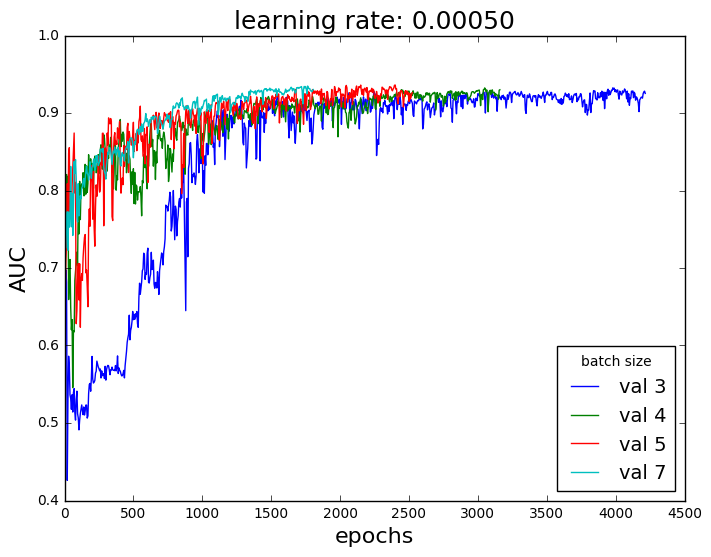

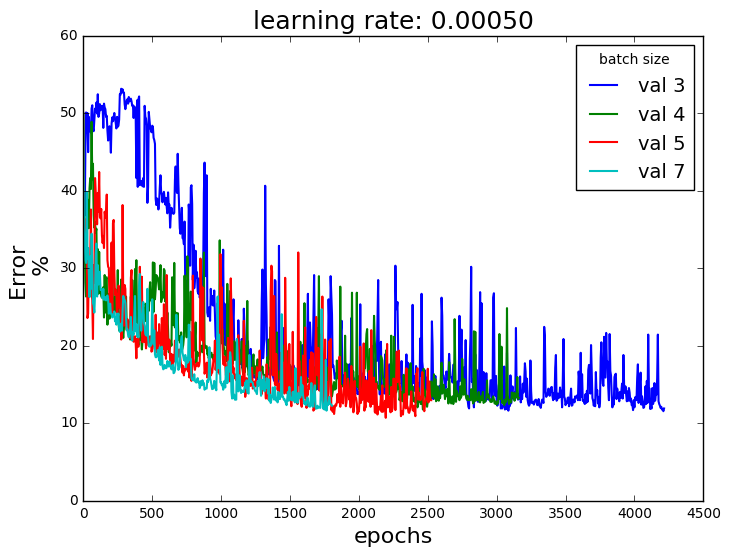

In [43]:
N_step = 5
epsilon = 1e-6
batch_size_array = np.array([3, 4, 5, 7])
#batch_size_array = np.array([5])

lr =5e-4
lr_array = np.ones(batch_size_array.shape)*lr #alpha

beta = epsilon #regularization parameters
beta_array = np.ones(batch_size_array.shape)*beta



import matplotlib
matplotlib.style.use('classic')
%matplotlib inline
fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l_batch.pred_step_array):
    if len(batch_size_array)>1:
        #plt.plot(pred_step,l_batch.train_auc_array[i],linewidth= 1.5 , label= 'train %d'%batch_size_array[i])
        plt.plot(pred_step,l_batch.valid_auc_array[i], '-', label= 'val %d'%batch_size_array[i])
        #plt.plot(pred_step,l_batch.test_auc_array[i], '--', label= 'test %d'%batch_size_array[i])
        plt.legend(title= 'batch size', loc= "best", fontsize= 14)
    else:    
        plt.plot(pred_step,l_batch.train_auc_array[i],linewidth= 1.5 ,  label= 'train')
        plt.plot(pred_step,l_batch.valid_auc_array[i], '-.', label= 'val')
        #plt.plot(pred_step,l_batch.test_auc_array[i], '--', label= 'test')
        plt.legend(title= 'batch size' %batch_size_array[i], loc= "best", fontsize= 14)
plt.ylim((.4,1))
plt.xlim((0,4500))        
plt.xlabel('epochs', fontsize= 16)
plt.ylabel('AUC', fontsize= 16)
tail= '_AWS_val_12_'
plt.title ('learning rate: %.5f' %lr_array[i], fontsize=18)
fig.savefig('../images/learning_rate_%.5f_val_auc%s.png'%(lr_array[i],tail), format='png', bbox_inches='tight')
#plt.show()

fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l_batch.pred_step_array):
    if len(batch_size_array)>1:
        #plt.plot(pred_step, [100. - x for x in l_batch.train_accuracy_array[i]],linewidth= 1.5 , label= 'train %d'%batch_size_array[i])
        plt.plot(pred_step, [100. - x for x in l_batch.valid_accuracy_array[i]], '-',linewidth= 1.5, label= 'val %d'%batch_size_array[i])
        #plt.plot(pred_step, [100. - x for x in l_batch.test_accuracy_array[i]],'--',linewidth= 1.5 , label= 'test %d'%batch_size_array[i])
        plt.legend(title= 'batch size', loc= "best", fontsize= 14)
    else:    
        plt.plot(pred_step,[100. - x for x in l_batch.train_accuracy_array[i]],linewidth= 1.5 ,  label= 'train')
        plt.plot(pred_step,[100. - x for x in l_batch.valid_accuracy_array[i]], '-.',linewidth= 1.5, label= 'val')
        #plt.plot(pred_step,[100. - x for x in l_batch.test_accuracy_array[i]],linewidth= 1.5 , '--', label= 'test')
        plt.legend(title= 'batch size %d' %batch_size_array[i], loc= "best", fontsize= 14)
plt.ylim((0,60))
plt.xlim((0,4500))        
plt.xlabel('epochs', fontsize= 16)
plt.ylabel('Error \n %', fontsize= 16)

plt.title ('learning rate: %.5f' %lr_array[i], fontsize=18)
fig.savefig('../images/learning_rate_%.5f_val_error%s.png'%(lr_array[i],tail), format='png', bbox_inches='tight')
plt.show()


## 1.2. Learning rate $\alpha$ selection

In [21]:
batch_size = 5 #fixed
beta = 0 #no regularization

lr_array = np.array([7e-4, 5e-4, 1e-4, 5e-5]) #alpha
batch_size_array = np.ones(lr_array.shape)*batch_size
beta_array = np.ones(lr_array.shape)*beta

l_lr= lenet5(train_dataset, valid_dataset, test_dataset, 
                   train_labels, valid_labels, test_labels, recording_step= 2)
l_lr.lenet5_run(batch_size_array, lr_array, beta_array)

batch size:5 

regularization : 0.00000

learning rate : 0.00050

num_steps:2529
[5, 28, 28, 6]
[5, 14, 14, 6]
[5, 10, 10, 16]
[5, 5, 5, 16]
[5, 120]
[12648, 28, 28, 6]
[12648, 14, 14, 6]
[12648, 10, 10, 16]
[12648, 5, 5, 16]
[12648, 120]
[1406, 28, 28, 6]
[1406, 14, 14, 6]
[1406, 10, 10, 16]
[1406, 5, 5, 16]
[1406, 120]
[10000, 28, 28, 6]
[10000, 14, 14, 6]
[10000, 10, 10, 16]
[10000, 5, 5, 16]
[10000, 120]
Initialized
Minibatch loss at step 0: 103.932770
Minibatch accuracy: 20.0%
Validation accuracy: 50.0%
AUC: 0.500
.................


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:190: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:191: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Minibatch loss at step 250: 0.675320
Minibatch accuracy: 60.0%
Validation accuracy: 50.1%
AUC: 0.501
.................
Minibatch loss at step 500: 0.625517
Minibatch accuracy: 80.0%
Validation accuracy: 50.1%
AUC: 0.502
.................
Minibatch loss at step 750: 0.691473
Minibatch accuracy: 60.0%
Validation accuracy: 49.8%
AUC: 0.495
.................
Minibatch loss at step 1000: 0.688438
Minibatch accuracy: 60.0%
Validation accuracy: 49.6%
AUC: 0.507
.................
Minibatch loss at step 1250: 0.697442
Minibatch accuracy: 40.0%
Validation accuracy: 52.3%
AUC: 0.518
.................
Minibatch loss at step 1500: 0.674772
Minibatch accuracy: 60.0%
Validation accuracy: 51.4%
AUC: 0.513
.................
Minibatch loss at step 1750: 0.708466
Minibatch accuracy: 40.0%
Validation accuracy: 50.0%
AUC: 0.587
.................
Minibatch loss at step 2000: 0.771182
Minibatch accuracy: 40.0%
Validation accuracy: 79.1%
AUC: 0.827
.................
Minibatch loss at step 2250: 1.531774
Minib

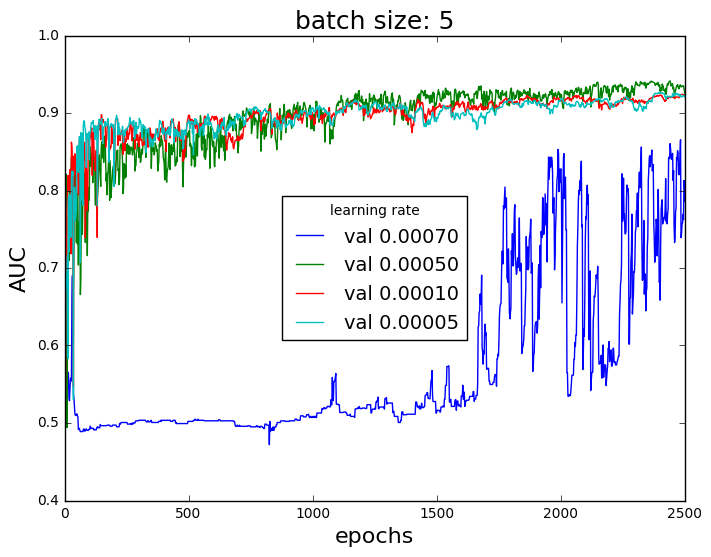

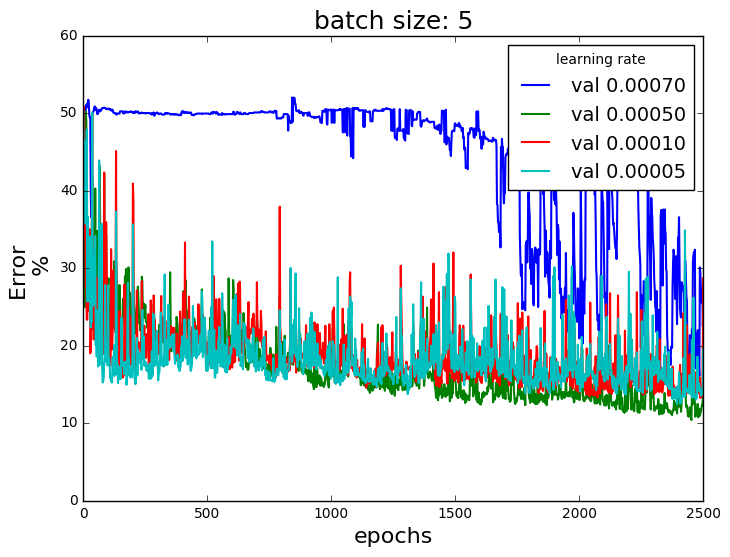

In [42]:
batch_size = 5 #fixed
beta = 0 #no regularization

lr_array = np.array([7e-4, 5e-4, 1e-4, 5e-5]) #alpha
batch_size_array = np.ones(lr_array.shape)*batch_size
beta_array = np.ones(lr_array.shape)*beta

fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l_lr.pred_step_array):
    if len(batch_size_array)>1:
        #plt.plot(pred_step,l_lr.train_auc_array[i],linewidth= 1.5 , label= 'train %.5f'%lr_array[i])
        plt.plot(pred_step,l_lr.valid_auc_array[i], '-', label= 'val %.5f'%lr_array[i])
        #plt.plot(pred_step,l_lr.test_auc_array[i], '--', label= 'test %.5f'%lr_array[i])
        plt.legend(title= 'learning rate', loc= "best", fontsize= 14)
    else:    
        #plt.plot(pred_step,l_lr.train_auc_array[i],linewidth= 1.5 ,  label= 'train')
        plt.plot(pred_step,l_lr.valid_auc_array[i], '-.', label= 'val')
        #plt.plot(pred_step,l_lr.test_auc_array[i], '--', label= 'test')
        plt.legend(title= 'learning rate %.5f' %lr_array[i], loc= "best", fontsize= 14)
plt.ylim((.4,1))  
plt.xlim((0,2500))        
plt.xlabel('epochs', fontsize= 16)
plt.ylabel('AUC', fontsize= 16)
tail= '_AWS_val_13'
plt.title ('batch size: %d' %batch_size, fontsize=18)
fig.savefig('../images/batch_size_%d_val_auc%s.png'%(batch_size_array[i],tail), format='png', bbox_inches='tight')
#plt.show()

fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l_lr.pred_step_array):
    if len(batch_size_array)>1:
        #plt.plot(pred_step, [100. - x for x in l_lr.train_accuracy_array[i]],linewidth= 1.5 , label= 'train %.5f'%lr_array[i])
        plt.plot(pred_step, [100. - x for x in l_lr.valid_accuracy_array[i]], '-',linewidth= 1.5, label= 'val %.5f'%lr_array[i])
        #plt.plot(pred_step, [100. - x for x in l_lr.test_accuracy_array[i]],'--',linewidth= 1.5 , label= 'test %.5f'%lr_array[i])
        plt.legend(title= 'learning rate', loc= "best", fontsize= 14)
    else:    
        #plt.plot(pred_step,[100. - x for x in l_lr.train_accuracy_array[i]],linewidth= 1.5 ,  label= 'train')
        plt.plot(pred_step,[100. - x for x in l_lr.valid_accuracy_array[i]], '-.',linewidth= 1.5, label= 'val')
        #plt.plot(pred_step,[100. - x for x in l_lr.test_accuracy_array[i]],linewidth= 1.5 , '--', label= 'test')
        plt.legend(title= 'learning rate %.5f' %lr_array[i], loc= "best", fontsize= 14)
plt.ylim((0,60)) 
plt.xlim((0,2500))        
plt.xlabel('epochs', fontsize= 16)
plt.ylabel('Error \n %', fontsize= 16)

plt.title ('batch size: %d' %batch_size, fontsize=18)
fig.savefig('../images/batch_size_%d_val_error%s.png'%(batch_size_array[i],tail), format='png', bbox_inches='tight')
plt.show()


## 1.3 Regularization selection

In [27]:
batch_size = 5 ##fixed
lr= .0005 #fixed
beta_array = np.array([0.99, 0.975, 0.95, 0.9]) # regularization
#beta_array = np.array([.05, .02]) #
batch_size_array = np.ones(beta_array.shape)*batch_size
#beta = [2e-3, 5e-3, 1e-3]
lr_array = np.ones(beta_array.shape)*lr

l_reg= lenet5(train_dataset, valid_dataset, test_dataset, 
                   train_labels, valid_labels, test_labels, recording_step= 5)

l_reg.lenet5_run(batch_size_array, lr_array, beta_array)

batch size:5 

regularization : 0.99000

learning rate : 0.00050

num_steps:2529
[5, 28, 28, 6]
[5, 14, 14, 6]
[5, 10, 10, 16]
[5, 5, 5, 16]
[5, 120]
[12648, 28, 28, 6]
[12648, 14, 14, 6]
[12648, 10, 10, 16]
[12648, 5, 5, 16]
[12648, 120]
[1406, 28, 28, 6]
[1406, 14, 14, 6]
[1406, 10, 10, 16]
[1406, 5, 5, 16]
[1406, 120]
[10000, 28, 28, 6]
[10000, 14, 14, 6]
[10000, 10, 10, 16]
[10000, 5, 5, 16]
[10000, 120]
Initialized
Minibatch loss at step 0: 326.640564
Minibatch accuracy: 20.0%
Validation accuracy: 50.0%
AUC: 0.500
.................


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:190: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:191: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Minibatch loss at step 250: 191.787994
Minibatch accuracy: 60.0%
Validation accuracy: 81.8%
AUC: 0.874
.................
Minibatch loss at step 500: 149.374008
Minibatch accuracy: 100.0%
Validation accuracy: 84.4%
AUC: 0.900
.................
Minibatch loss at step 750: 116.916397
Minibatch accuracy: 80.0%
Validation accuracy: 86.1%
AUC: 0.914
.................
Minibatch loss at step 1000: 91.053741
Minibatch accuracy: 80.0%
Validation accuracy: 87.3%
AUC: 0.917
.................
Minibatch loss at step 1250: 71.224098
Minibatch accuracy: 80.0%
Validation accuracy: 87.6%
AUC: 0.927
.................
Minibatch loss at step 1500: 55.567245
Minibatch accuracy: 80.0%
Validation accuracy: 86.0%
AUC: 0.927
.................
Minibatch loss at step 1750: 44.396927
Minibatch accuracy: 80.0%
Validation accuracy: 88.2%
AUC: 0.931
.................
Minibatch loss at step 2000: 33.931675
Minibatch accuracy: 100.0%
Validation accuracy: 88.8%
AUC: 0.940
.................
Minibatch loss at step 2250: 2

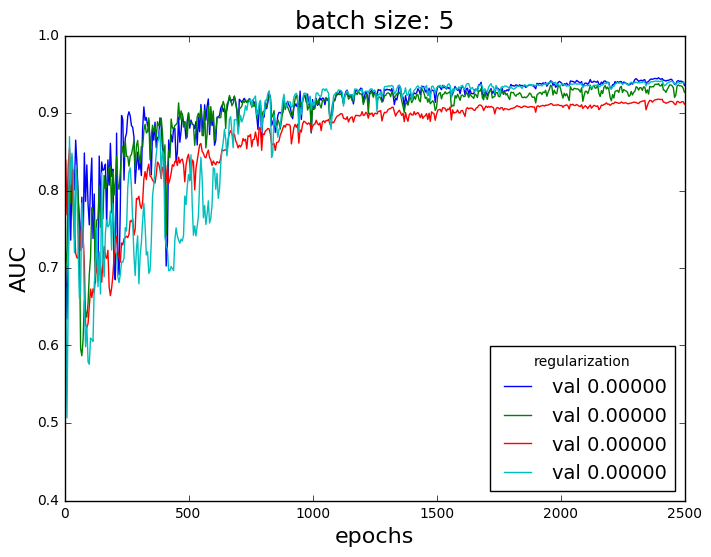

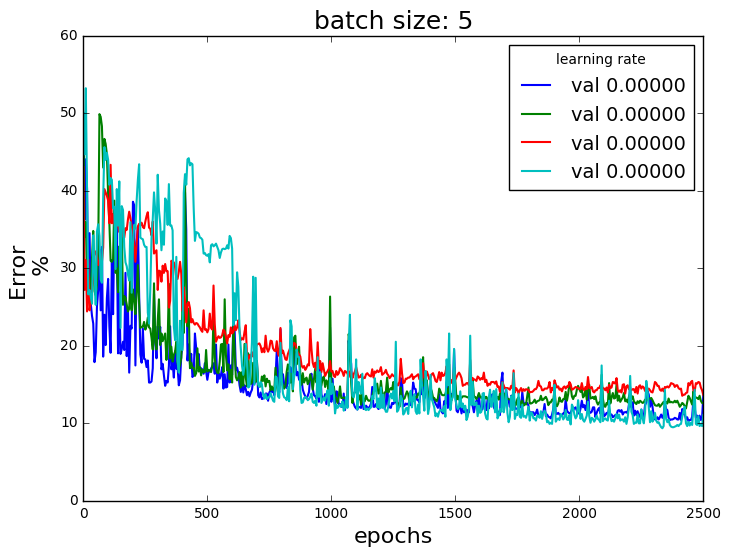

In [44]:
fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l_reg.pred_step_array):
    if len(batch_size_array)>1:
        #plt.plot(pred_step,l_reg.train_auc_array[i],linewidth= 1.5 , label= 'train %.5f'%beta_array[i])
        plt.plot(pred_step,l_reg.valid_auc_array[i], '-', label= 'val %.5f'%beta_array[i])
        #plt.plot(pred_step,l_reg.test_auc_array[i], '--', label= 'test %.5f'%beta_array[i])
        plt.legend(title= 'regularization', loc= "best", fontsize= 14)
    else:    
        #plt.plot(pred_step,l_reg.train_auc_array[i],linewidth= 1.5 ,  label= 'train')
        plt.plot(pred_step,l_reg.valid_auc_array[i], '-.', label= 'val')
        #plt.plot(pred_step,l_reg.test_auc_array[i], '--', label= 'test')
        plt.legend(title= 'regularization %.5f' %beta_array[i], loc= "best", fontsize= 14)
plt.xlim((0,2500)) 
plt.ylim((0.4,1)) 
plt.xlabel('epochs', fontsize= 16)
plt.ylabel('AUC', fontsize= 16)
tail= '_AWS_val_15'
plt.title ('batch size: %d' %batch_size, fontsize=18)
fig.savefig('../images/batch_size_%d_lr_%.6f_val_auc%s.png'%(batch_size_array[i],lr_array[i],tail), format='png', bbox_inches='tight')
#plt.show()

fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l_reg.pred_step_array):
    if len(batch_size_array)>1:
        #plt.plot(pred_step, [100. - x for x in l_reg.train_accuracy_array[i]],linewidth= 1.5 , label= 'train %.5f'%beta_array[i])
        plt.plot(pred_step, [100. - x for x in l_reg.valid_accuracy_array[i]], '-',linewidth= 1.5, label= 'val %.5f'%beta_array[i])
        #plt.plot(pred_step, [100. - x for x in l_reg.test_accuracy_array[i]],'--',linewidth= 1.5 , label= 'test %.5f'%beta_array[i])
        plt.legend(title= 'learning rate', loc= "best", fontsize= 14)
    else:    
        #plt.plot(pred_step,[100. - x for x in l_reg.train_accuracy_array[i]],linewidth= 1.5 ,  label= 'train')
        plt.plot(pred_step,[100. - x for x in l_reg.valid_accuracy_array[i]], '-.',linewidth= 1.5, label= 'val')
        #plt.plot(pred_step,[100. - x for x in l_reg.test_accuracy_array[i]],linewidth= 1.5 , '--', label= 'test')
        plt.legend(title= 'learning rate %.5f' %beta_array[i], loc= "best", fontsize= 14)
plt.xlim((0,2500))  
plt.ylim((0,60)) 
plt.xlabel('epochs', fontsize= 16)
plt.ylabel('Error \n %', fontsize= 16)

plt.title ('batch size: %d' %batch_size, fontsize=18)
fig.savefig('../images/batch_size_%dlr_%.6f_val_error%s.png'%(batch_size_array[i],lr_array[i],tail), format='png', bbox_inches='tight')
plt.show()


## Final model 

In [63]:
batch_size = 5 ##fixed
lr= .0005 #fixed
beta_array = np.array([0.97]) # regularization
#beta_array = np.array([.05, .02]) #
batch_size_array = np.ones(beta_array.shape)*batch_size
#beta = [2e-3, 5e-3, 1e-3]
lr_array = np.ones(beta_array.shape)*lr

N_step = 100

l_final= lenet5(train_dataset, valid_dataset, test_dataset, 
                   train_labels, valid_labels, test_labels, recording_step= N_step)

l_final.lenet5_run(batch_size_array, lr_array, beta_array)

batch size:5 

regularization : 0.97000

learning rate : 0.00050

num_steps:2529
[5, 28, 28, 6]
[5, 14, 14, 6]
[5, 10, 10, 16]
[5, 5, 5, 16]
[5, 120]
[12648, 28, 28, 6]
[12648, 14, 14, 6]
[12648, 10, 10, 16]
[12648, 5, 5, 16]
[12648, 120]
[1406, 28, 28, 6]
[1406, 14, 14, 6]
[1406, 10, 10, 16]
[1406, 5, 5, 16]
[1406, 120]
[10000, 28, 28, 6]
[10000, 14, 14, 6]
[10000, 10, 10, 16]
[10000, 5, 5, 16]
[10000, 120]
Initialized
Minibatch loss at step 0: 469.471802
Minibatch accuracy: 20.0%
Validation accuracy: 50.0%
AUC: 0.500
.................


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:190: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:191: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Minibatch loss at step 250: 189.511597
Minibatch accuracy: 40.0%
Validation accuracy: 73.0%
AUC: 0.769
.................
Minibatch loss at step 500: 148.522217
Minibatch accuracy: 60.0%
Validation accuracy: 80.9%
AUC: 0.858
.................
Minibatch loss at step 750: 116.593758
Minibatch accuracy: 80.0%
Validation accuracy: 83.6%
AUC: 0.890
.................
Minibatch loss at step 1000: 91.651352
Minibatch accuracy: 80.0%
Validation accuracy: 83.2%
AUC: 0.897
.................
Minibatch loss at step 1250: 71.702644
Minibatch accuracy: 100.0%
Validation accuracy: 85.9%
AUC: 0.922
.................
Minibatch loss at step 1500: 56.905407
Minibatch accuracy: 60.0%
Validation accuracy: 85.8%
AUC: 0.916
.................
Minibatch loss at step 1750: 45.593212
Minibatch accuracy: 60.0%
Validation accuracy: 87.6%
AUC: 0.930
.................
Minibatch loss at step 2000: 34.758274
Minibatch accuracy: 100.0%
Validation accuracy: 87.7%
AUC: 0.933
.................
Minibatch loss at step 2250: 2

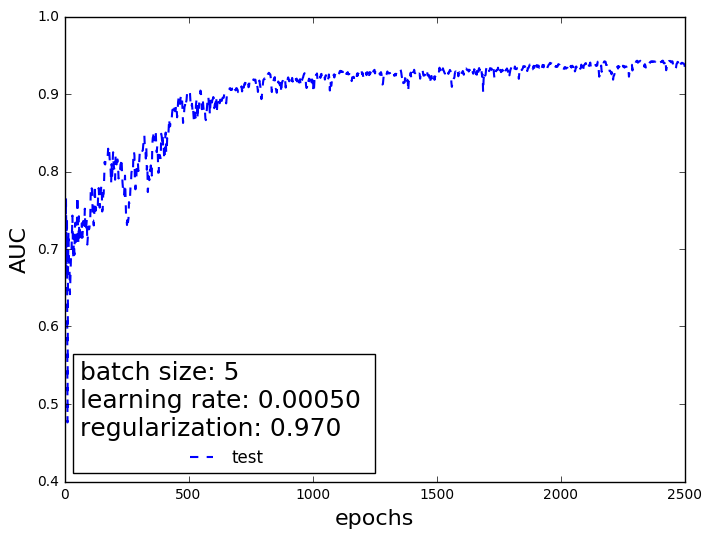

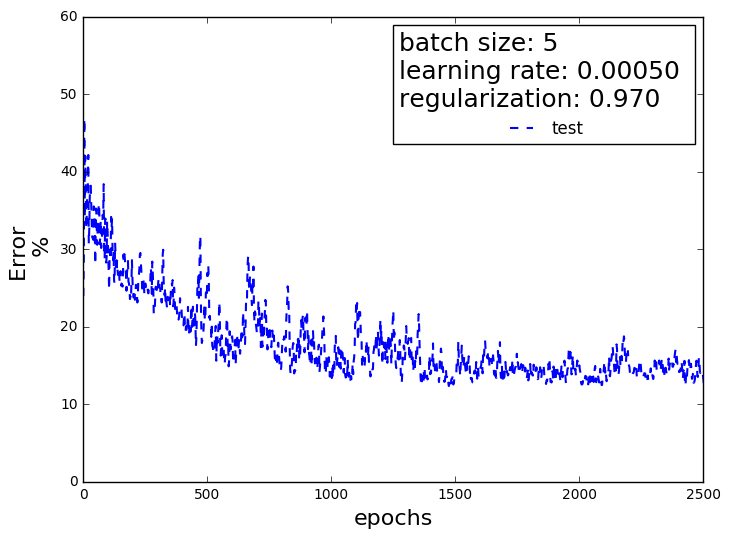

In [60]:
fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l_final.pred_step_array):
   
    #plt.plot(pred_step,l_final.train_auc_array[i],linewidth= 1.5 ,  label= 'train')
    #plt.plot(pred_step,l_final.valid_auc_array[i], '-.',linewidth= 1.5 , label= 'val')
    plt.plot(pred_step,l_final.test_auc_array[i], '--',linewidth= 1.5 , label= 'test')

plt.xlim((0,2500))
plt.ylim((0.4,1)) 
plt.xlabel('epochs', fontsize= 16)
plt.ylabel('AUC', fontsize= 16)
tail= '_AWS_test_17'
legend = plt.legend (title= 'batch size: %d \nlearning rate: %.5f \nregularization: %.3f' %(batch_size, lr_array[i], beta_array[i]), fontsize=12, loc='best')
plt.setp(legend.get_title(),fontsize=18)
fig.savefig('../images/batch_size_%d_lr_%.6f_reg_%.3f_val_auc%s.png'%(batch_size_array[i],lr_array[i], beta_array[i],tail), format='png', bbox_inches='tight')
#plt.show()

fig = plt.figure(figsize=(8,6), facecolor= 'white')
for i, pred_step in enumerate(l_final.pred_step_array):
 
    #plt.plot(pred_step,[100. - x for x in l_final.train_accuracy_array[i]],linewidth= 1.5 ,  label= 'train')
    #plt.plot(pred_step,[100. - x for x in l_final.valid_accuracy_array[i]], '-.',linewidth= 1.5, label= 'val')
    plt.plot(pred_step,[100. - x for x in l_final.test_accuracy_array[i]], '--',linewidth= 1.5 , label= 'test')
    #plt.legend(title= 'learning rate %.5f' %beta_array[i], loc= "best", fontsize= 14)
plt.xlim((0,2500))
plt.ylim((0,60)) 
plt.xlabel('epochs', fontsize= 16)
plt.ylabel('Error \n %', fontsize= 16)

legend = plt.legend (title= 'batch size: %d \nlearning rate: %.5f \nregularization: %.3f' %(batch_size, lr_array[i], beta_array[i]), fontsize=12, loc='best')
plt.setp(legend.get_title(),fontsize=18)

fig.savefig('../images/batch_size_%d_lr_%.6f_reg_%.3f_val_error%s.png'%(batch_size_array[i],lr_array[i], beta_array[i],tail), format='png', bbox_inches='tight')
plt.show()


## 1.1.1 Print activation layer
### 1.1.1.a Plot weights and biases from first layer

In [61]:
def draw_grids(ax, image, N):
    """Draw grids in an image
    
    Args:
    ax: ax from figure
    image: image to be plot
    N: separation of grids
    
    Returns:
    
    ax
    
    """
    for x in range(im_total.shape[0]/N):
        ax.axhline(x*N, lw=1, color='k', zorder=5, linestyle= '-')
    for x in range(im_total.shape[1]/5):
        ax.axvline(x*N, lw=1, color='k', zorder=5)
        
    return ax




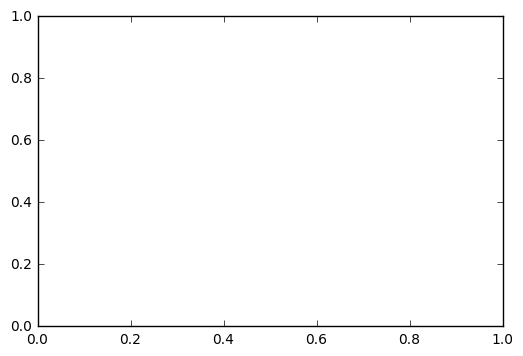

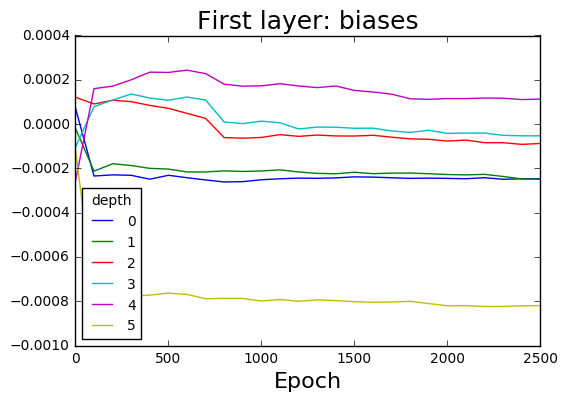

In [64]:
l= l_final
#Biases
#N_step = 100
df = pd.DataFrame.from_records(l.layer1_biases)
df = df.set_index(df.index.values*N_step)
df.head()

plt.cla()
fig, ax = plt.subplots(facecolor= "white")
df.plot(ax= ax)
ax.legend(title= "depth", loc= 'best', fontsize=10)
ax.set_title("First layer: biases", fontsize=18)
ax.set_xlabel("Epoch", fontsize=16)
tail= 'l_reg_0.97_AWS_16'
fig.savefig("../images/bias_batch_size_%d_learning_rate_%.5f, %s.png"%(batch_size_array,lr_array, tail),bbox_inches='tight')
plt.show()

26


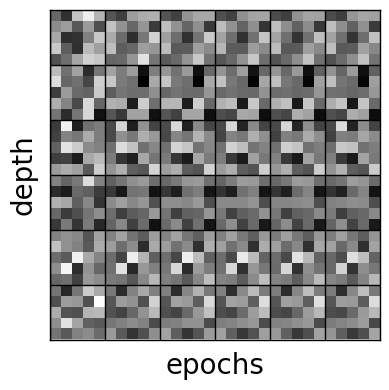

In [65]:
l= l_final
im_total = None
print(len(l.layer1_weights))

for i, im in enumerate(l.layer1_weights):
    if i ==0:
        im_total = np.array(im.reshape((im.shape[0]*im.shape[3],im.shape[1])))
    elif i%5==0:
        im_total = np.concatenate((im_total, np.array(im.reshape((im.shape[0]*im.shape[3],im.shape[1])))), axis=1)
        
fig, ax = plt.subplots(1, 1, tight_layout=True, dpi=100, facecolor= 'white')
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.imshow(im_total, cmap= "gray", extent=[0,im_total.shape[0],0,im_total.shape[1]], interpolation = 'none')
draw_grids(ax, im_total, 5)
ax.set_ylabel('depth', fontsize=20)
ax.set_xlabel('epochs', fontsize=20)
#ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
tail= '_l_reg_0.97_AWS_17'
fig.savefig("../images/weights_batch_size_%d_learning_rate_%.5f%s.png"%(batch_size_array,lr_array, tail),bbox_inches='tight')
plt.show()
plt.close()

### 1.1.1.b Plot activation of first layer

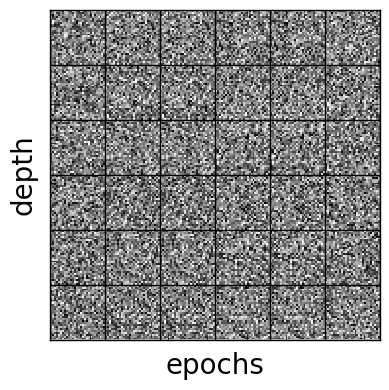

In [66]:
im_total = None
for i, im in enumerate(l.layer1_activation):
    if i ==0:
        im_total = np.array(im[np.random.choice(range(batch_size_array)),:,:,:].reshape((im.shape[1]*im.shape[3],im.shape[2])))
    elif i%5==0:
        im_total = np.concatenate((im_total, np.array(im[np.random.choice(range(batch_size_array)),:,:,:].reshape((im.shape[1]*im.shape[3],im.shape[2])))), axis=1)

fig, ax = plt.subplots(1, 1, tight_layout=True, dpi=100, facecolor= 'white')
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
draw_grids(ax, im_total, 28)
ax.imshow(im_total, cmap= "gray", extent=[0,im_total.shape[1],0,im_total.shape[0]], interpolation = 'none')
ax.set_ylabel('depth', fontsize=20)
ax.set_xlabel('epochs', fontsize=20)

#ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()
tail= '_l_reg_0.97_AWS_11'
fig.savefig("../images/activation_batch_size_%d_learning_rate_%.5f%s.png"%(batch_size_array,lr_array, tail),bbox_inches='tight')
#fig.savefig("../MLNP/capstone/images/activation_batch_size_%d_learning_rate_%.5f.png"%(batch_size_array,lr_array),bbox_inches='tight')

plt.close()